In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numba as nb
import time
import ROOT

#from scipy.linalg.blas import zgemm
# from sklearn.linear_model import LinearRegression

Welcome to JupyROOT 6.26/08


In [2]:
# load style
from ROOT import gROOT

path = '/Users/yy/cernbox/'
# path = '/eos/user/y/youyou/'
gROOT.SetMacroPath(path+"atlasstyle/")
gROOT.LoadMacro("AtlasLabels.C")
gROOT.LoadMacro("AtlasStyle.C")
gROOT.LoadMacro("AtlasUtils.C")
from ROOT import SetAtlasStyle, ATLASLabel, myText, myMarkerText
SetAtlasStyle()


Applying ATLAS style settings...



In [4]:
# load data

data_folder = './data/'
pulse = np.loadtxt(data_folder + 'pule_shape.txt')  # pulse shape
adc = np.loadtxt(data_folder + 'adc_out.txt')       # simulated adc output
signal = np.loadtxt(data_folder + 'signal.txt')     # delta func signal
pileup = np.loadtxt(data_folder + 'pileup.txt')     # pileup noise

of_coeff = np.loadtxt(data_folder + 'of_coeffs.txt')# optimal filter coefficients 
of_out = np.loadtxt(data_folder + 'of_out.txt')     # optimal filter output with above coeffs

The implementation of the FIR filters are from Jonathan Le Roy Sievers

In [11]:
# function of quadratic FIR filter without matrix calculation
# slower
# use coeff from matrix calculation

@nb.njit(parallel=True)
def apply_filt_quadratic(adc,nleft,nright,coeffs):
    out=0*adc
    offset=coeffs[nleft+nright+1]
    linear=coeffs[:nleft+nright+1]
    quadratic=coeffs[nleft+nright+2:]    
    for i in nb.prange(nleft,len(adc)-nright-1):
        tmp=offset
        for j in range(nleft+nright+1):
            val=adc[i-nleft+j]
            tmp=tmp+linear[j]*val+quadratic[j]*val**2
        out[i]=tmp
    return out

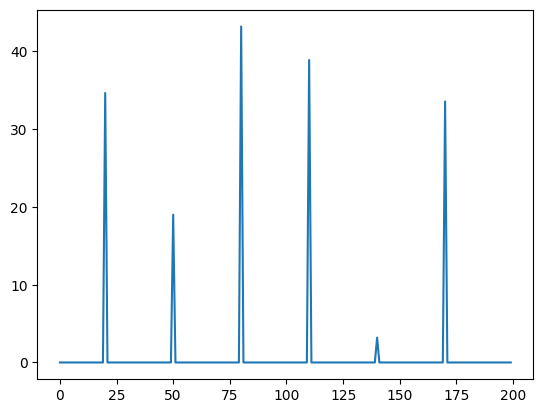

In [82]:
# look at signal shape

sig_i = [i for i in list(range(len(signal))) if signal[i] > 0]

for i in range(len(sig_i)%2):
    if sig_i[i+1]-sig_i[i]<20:
        print(sig_i[i+1],sig_i[i])

plt.plot(signal[10000:10200])

In [3]:
# process the data

npad=len(adc)-len(pileup)

signal=np.hstack([signal,np.zeros(npad)])
pileup=np.hstack([pileup,np.zeros(npad)])
pp=0*pileup
pp[:len(pulse)]=pulse
pred=np.fft.irfft(np.fft.rfft(pp)*np.fft.rfft(pileup+signal))

i1=30000
i2=31300


In [10]:
# build the design matrix for linear FIR

nleft=30  #how many samples to the left of our data point we are allowed to use
lag=8 #how many samples to the right of our sample we are allowed to use
nright=lag+1 #offset by 1 is because of python indexing

nn=nleft+nright+2
mat=np.zeros([len(adc),nn])
ncut=10000 #snip this many samples off the ends to avoid edge effects in simulations.  
mm=np.zeros([len(adc)-2*ncut,nn])
for i in range(nn-1):
    mm[:,i]=adc[ncut-nleft+i:-ncut-nleft+i]
mm[:,-1]=1 #add a constant offset as a parameter, since samples were not zero mean

In [11]:
# build the design matrix for cubic FIR

mm_big=np.hstack([mm,mm[:,:-1]**2,mm[:,:-1]**3]) #let us use the square and the cube of the ADC samples


In [ ]:
if 0:  #you can do a bit better, but only a bit, if you look at correlations of adc samples with their neighbors.
           #so, we will skip it.  Depending on how much you want to squeeze out, you could play with this and code
           #will work correctly
    nneighb=2
    for ii in range(1,nneighb+1):
        tmp=np.zeros([mm.shape[0],nn-ii-1])
        for j in range(nn-ii-1):
            fwee=np.roll(adc,j-nleft)*np.roll(adc,j-nleft-ii)
            tmp[:,j]=fwee[ncut:-ncut]
        mm_big=np.hstack([mm,tmp])

In [12]:
# this is the true signal

ss=(signal+pileup)[ncut:-ncut]

In [13]:
#do the linear least squares fits, both for standard FIR, and using ADC squared as a value
lhs=mm.T@mm
rhs=mm.T@ss
coeffs=np.linalg.inv(lhs)@rhs
pred1=mm@coeffs
print('linear std is ',np.std((ss-pred1)[ncut:-ncut]))

linear rms is  0.6713704736289167


In [14]:
#do the cubic least squares fits
lhs2=mm_big.T@mm_big
rhs2=mm_big.T@ss
coeffs2=np.linalg.inv(lhs2)@rhs2
pred2=mm_big@coeffs2
print('nonlinear std is ',np.std((ss-pred2)[ncut:-ncut]))

nonlinear rms is  0.3177242366545243


### `pred1` is the output for linear FIR, `pred2` is the outpout for cubic FIR

In [57]:
# the expected standard deviation for match filter
# we didnt use this in this notebook, just took it as a reference

def error_bar(pred, adc, h):
    difference = pred - adc
    noise_variance = np.mean(difference**2)
    
    denominator = np.dot(h, np.conj(h))
    
    return np.sqrt(noise_variance / denominator)

error_bar(of_out[2+10000:], adc[10000:-2], of_coeff)

2.0577646945837524

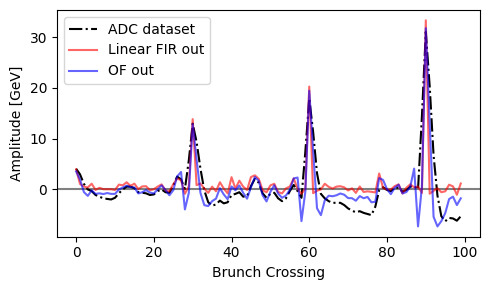

In [77]:
# In case you haven't known the shape of the signal output

plt.figure(figsize=(5,3))

plt.axhline(0, color='gray', linestyle='-') 

plt.plot(adc[30003:30103], 'k-.', alpha=1, label='ADC dataset')
#plt.plot(ss[30002-10000:30102-10000], 'g', alpha=0.9, label='$E_{true}$')
plt.plot(pred2[30000-10000:30100-10000], 'r', alpha=0.6, label='Linear FIR out')
#plt.plot(pred2[30000-10000:30100-10000], '--', label='non-Linear FIR out')
plt.plot(of_out[30005:30105], 'b', alpha=0.6, label='OF out')


plt.xlabel('Brunch Crossing')
plt.ylabel('Amplitude [GeV]')

plt.legend()
plt.tight_layout()
plt.savefig('data1.pdf')
plt.show()

### effects fo the number of left and right coefficients of the FIR

In [187]:
# if anyone is interested in 
# how std change with the number of left and right coefficients of the FIR

def std_calc(nleft, nright):

    nn=int(nleft+nright+2)
    mat=np.zeros([len(adc),nn])
    ncut=10000 #snip this many samples off the ends to avoid edge effects in simulations.  
    mm=np.zeros([len(adc)-2*ncut,nn])
    for i in range(nn-1):
        mm[:,i]=adc[ncut-nleft+i:-ncut-nleft+i]
    mm[:,-1]=1 #add a constant offset as a parameter, since samples were not zero 

    #do the least squares fits, both for standard FIR, and using ADC squared as a value
    lhs=mm.T@mm
    rhs=mm.T@ss
    coeffs=np.linalg.inv(lhs)@rhs
    pred1=mm@coeffs
    
    return np.std((ss-pred1)[ncut:-ncut]), nn-2


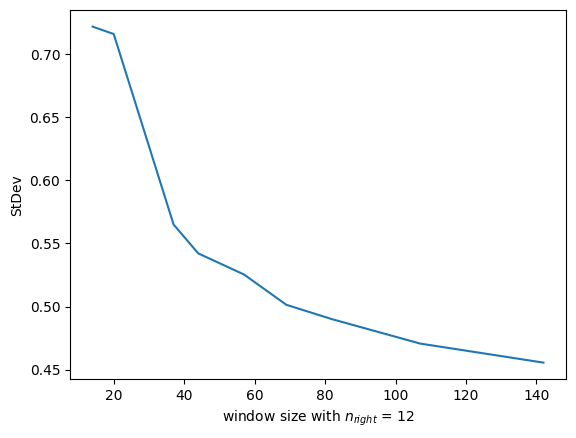

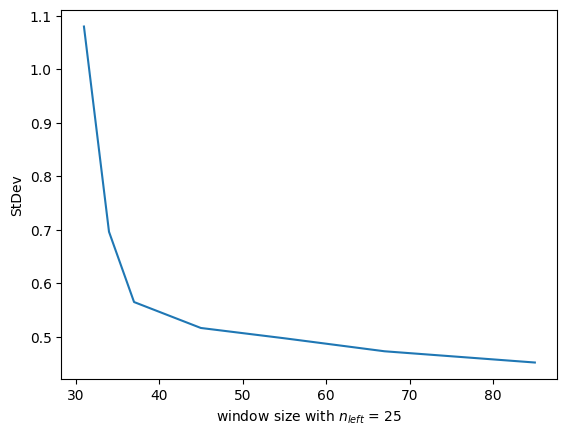

In [193]:
n_ls = [2,8, 25, 32,45,57, 70, 95, 130]
n_rs = [ 6,  9, 12, 20, 30, 42, 60]

rnss, win_sizes = [] , []
for n in n_ls:
    rns, win = rnss_calc(n, 12)
    rnss += [rns]
    win_sizes += [win]
plt.plot(win_sizes, rnss)
plt.ylabel('StDev')
plt.xlabel('window size with $n_{right}$ = 12')
plt.show()

rnss, win_sizes = [] , []
for n in n_rs:
    rns, win = rnss_calc(25, n)
    rnss += [rns]
    win_sizes += [win]
plt.plot(win_sizes, rnss)
plt.ylabel('StDev')
plt.xlabel('window size')
plt.ylabel('StDev')
plt.xlabel('window size with $n_{left}$ = 25')
plt.show()

## residual $\Delta E$ of FIR

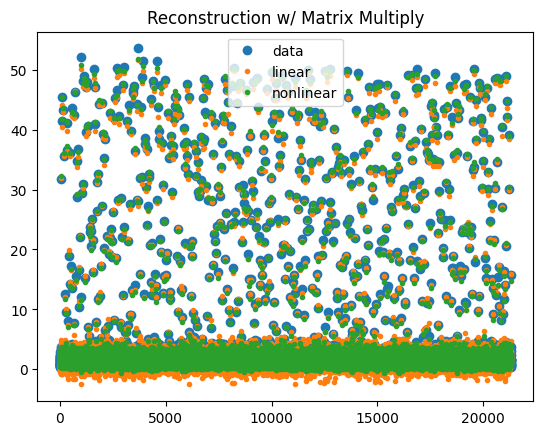

<Figure size 640x480 with 0 Axes>

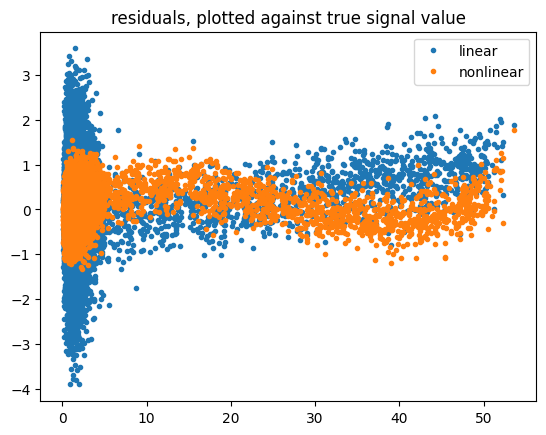

<Figure size 640x480 with 0 Axes>

In [152]:
plt.ion()

plt.figure(1)
plt.clf()
plt.plot(ss[i1:i2],'o')
plt.plot(pred1[i1:i2],'.')
plt.plot(pred2[i1:i2],'.')
plt.legend(['data','linear','nonlinear'])
plt.title('Reconstruction w/ Matrix Multiply')
plt.show()
plt.savefig('nonlinear_reconstruction.png')

#plot the residuals with true signal on x-axis.  We *hope* that residual will not really
#depend on true signal, since that means our reconstruction where we care about it is
#unbiased.
i2=i2+20000
plt.figure(3)
plt.clf()
plt.plot(ss[i1:i2],ss[i1:i2]-pred1[i1:i2],'.')
plt.plot(ss[i1:i2],ss[i1:i2]-pred2[i1:i2],'.')
plt.title('residuals, plotted against true signal value')
plt.legend(['linear','nonlinear'])
plt.show()
plt.savefig('nonlinear_residuals.png')
           

reconstructed series in  1.5498030185699463


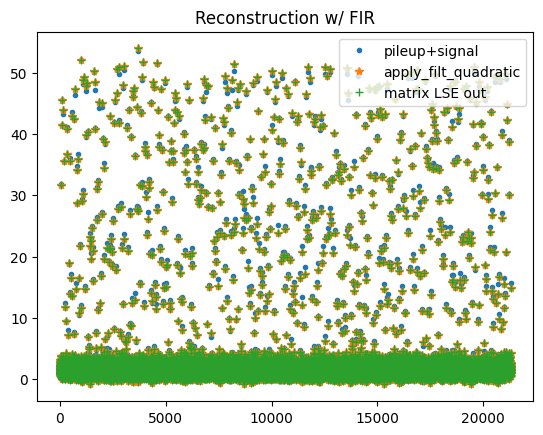

sanity check - scatter in matrix vs. FIR (should be zero):  5.373841985098962e-15


In [20]:
if True:  #this repeats the reconstruction but explicitly as a FIR filter
          #if you don't want to import numba, set this to False and trues that I haven't lied.
          #I also didn't code up the cubic FIR, so this will only work if you set to quadratic

#first do a short call so numba compiles and we get valid timing

    mm_middle=np.hstack([mm,mm[:,:-1]**2])
    # ss=(signal+pileup)[ncut:-ncut]
    lhs3=mm_middle.T@mm_middle
    rhs3=mm_middle.T@ss
    coeffs3=np.linalg.inv(lhs3)@rhs3
    pred_quad_only=mm_middle@coeffs3

    # out=apply_filt_quadratic(adc[:1000],nleft,nright,coeffs3) # pred?
    for i in range(1): 
        t1=time.time()
        out=apply_filt_quadratic(adc,nleft,nright,coeffs3)
        t2=time.time()
        print('reconstructed series in ',t2-t1)

    truth=signal+pileup
    
    plt.figure(2)
    plt.clf()
    plt.plot(truth[i1+ncut:i2+ncut],'.', label='pileup+signal')
    plt.plot(out[i1+ncut:i2+ncut],'*', label='apply_filt_quadratic')
    plt.plot(pred_quad_only[i1:i2],'+', label='matrix LSE out')
    plt.title('Reconstruction w/ FIR')
    plt.legend()
    plt.show()

    print('sanity check - scatter in matrix vs. FIR (should be zero): ',np.std(out[i1+ncut:i2+ncut]-pred_quad_only[i1:i2]))

In [21]:
n_start, n_end = 0, 980000

# true_signal =signal[n_start+10000: n_end+10000]
true_signal = ss[n_start: n_end]
pred1 = pred1[n_start: n_end]
pred2 = pred2[n_start: n_end]
of_pred = of_out[n_start+5+10000: n_end+5+10000]

In [43]:
bins = np.linspace(0, 50, 11)
indices, x = [], []

for j in range(len(bins)-1):
    x += [(bins[j] + bins[j+1])/2]
    indices += [[i for i in range(len(true_signal)) if true_signal[i] >= bins[j] and true_signal[i] < bins[j+1]]]
    # indices += [[i for i in range(len(true_signal)) if true_signal[i] > bins[j] and true_signal[i] <= bins[j+1]]]

## seperate into diff ranges of $E_{true}$ and analyze the distribution of $\Delta E$

analyze the distribution of mean, std, 98% median within whole range of E_true

In [23]:
def arr_generator(e_diff, indices=indices):
    mean, std, median, lower_98, higher_98, scale_mean, scale_std = [], [], [], [], [], [], []

    for i_arr in indices:
        data = [e_diff[i] for i in i_arr]
        # indice += [len(i_arr)]
        
        mean += [np.mean(data)]
        std += [np.std(data)]

        scales = [e_diff[i]/true_signal[i] for i in i_arr]
        scale_mean += [np.mean(scales)]
        scale_std += [np.std(scales)]
        
        sorted_signal = np.sort(data)
        quantiles = np.percentile(sorted_signal, 1), np.percentile(sorted_signal, 99)
        filtered_signal = sorted_signal[(sorted_signal >= quantiles[0]) & (sorted_signal <= quantiles[1])]
        median += [np.median(filtered_signal)]
        lower_98 += [quantiles[0]]
        higher_98 += [quantiles[1]]
    
    return mean, std, median, lower_98, higher_98, scale_mean, scale_std

In [24]:
e_diff_of = [i-j for i,j in zip(of_pred, true_signal)]

mean_of, std_of, median_of, lower_98_of, higher_98_of, scale_mean_of, scale_std_of = arr_generator(e_diff_of)


e_diff_lin = [i-j for i,j in zip(pred1, true_signal)]

mean_lin, std_lin, median_lin, lower_98_lin, higher_98_lin, scale_mean_lin, scale_std_lin = arr_generator(e_diff_lin)


e_diff_quad = [i-j for i,j in zip(pred_quad_only, true_signal)]

mean_quad, std_quad, median_quad, lower_98_quad, higher_98_quad, scale_mean_quad, scale_std_quad = arr_generator(e_diff_quad)


e_diff_cubic = [i-j for i,j in zip(pred2, true_signal)]

mean_cubic, std_cubic, median_cubic, lower_98_cubic, higher_98_cubic, scale_mean_cubic, scale_std_cubic = arr_generator(e_diff_cubic)

### calculated the std of each filter

Standard Deviation (e_diff_of): 3.2879159420938806
Standard Deviation (e_diff_lin): 0.6965547055116466
Standard Deviation (e_diff_quad): 0.38957292757355994
Standard Deviation (e_diff_cubic): 0.32804745215253894


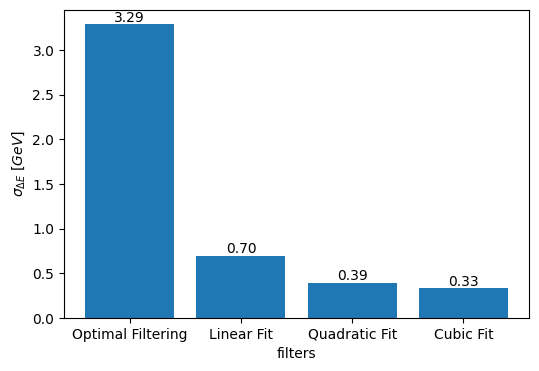

In [115]:
e_diff_lin_std = np.std(e_diff_lin)
e_diff_of_std = np.std(e_diff_of)
e_diff_quad_std = np.std(e_diff_quad)
e_diff_cubic_std = np.std(e_diff_cubic)

print("Standard Deviation (e_diff_of):", e_diff_of_std)
print("Standard Deviation (e_diff_lin):", e_diff_lin_std)
print("Standard Deviation (e_diff_quad):", e_diff_quad_std)
print("Standard Deviation (e_diff_cubic):", e_diff_cubic_std)


## the distribution of $\Delta E$ for three FIR and OF

In [116]:
# write data cuz run the func each time takes too long time

hist_lin= [0, 3, 5, 3, 12, 13, 23, 44, 57, 77, 104, 161, 191, 239, 313, 398, 466, 536, 714, 787, 992, 1137, 1369, 1727, 2045, 2483, 3135, 4051, 5040, 6609, 8478, 10640, 13626, 17364, 21055, 25820, 30536, 35039, 39934, 44088, 47998, 50999, 52751, 54611, 54168, 53703, 51848, 49706, 45735, 41573, 37425, 32396, 27505, 22613, 17846, 13933, 10679, 7789, 5859, 4216, 3144, 2415, 1862, 1537, 1245, 1018, 850, 741, 626, 545, 471, 442, 372, 343, 258, 232, 231, 197, 157, 159, 112, 100, 83, 68, 48, 28, 18, 9, 13, 3, 3, 0, 2, 0, 0, 0, 0, 0, 1] 
hist_quad= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 7, 20, 39, 122, 243, 450, 916, 1664, 3026, 4971, 8077, 12604, 18803, 27813, 38589, 50811, 64146, 76241, 86337, 92106, 93132, 87600, 78118, 65372, 52731, 39390, 27930, 19070, 12169, 7617, 4448, 2511, 1447, 743, 365, 185, 99, 46, 17, 14, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
hist_cubic= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 11, 20, 61, 122, 260, 531, 1089, 2167, 3977, 7318, 12616, 20864, 32487, 47344, 65261, 83325, 98904, 108515, 109285, 102093, 87734, 68818, 49806, 32878, 20447, 11602, 6360, 3256, 1553, 705, 343, 142, 66, 17, 12, 5, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: Linear Fit (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Quadratic Fit (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Cubic Fit (Potential memory leak).
Info in <TCanvas::Print>: pdf file distr3.pdf has been created


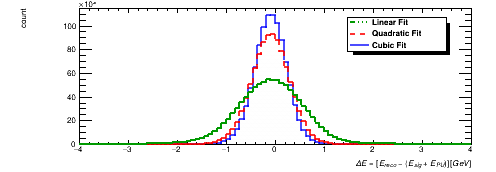

In [205]:
n_bins = 88
x_min = -4
x_max = 4

filters = ['Optimal Filtering', 'Linear Fit', 'Quadratic Fit', 'Cubic Fit']

#canvas.Clear()
canvas = ROOT.TCanvas("canvas", "Signal Graph", 500, 200)
h1 = ROOT.TH1F(filters[1], filters[1], n_bins, x_min, x_max)
h2 = ROOT.TH1F(filters[2], filters[2], n_bins, x_min, x_max)
h3 = ROOT.TH1F(filters[3], filters[3], n_bins, x_min, x_max)

h1.SetContent(np.array(hist_lin, dtype=np.float64))
h2.SetContent(np.array(hist_quad, dtype=np.float64))
h3.SetContent(np.array(hist_cubic, dtype=np.float64))

h1.SetFillColorAlpha(ROOT.kBlue, 0)
h1.SetFillStyle(3005)                   
h2.SetFillColorAlpha(ROOT.kRed, 0)      
h2.SetFillStyle(3013)        
h3.SetFillColorAlpha(ROOT.kSpring-8, 0)      
h3.SetFillStyle(3007)    

h3.SetLineWidth(2)
h3.SetLineColorAlpha(ROOT.kBlue, 0.7) 
h3.SetLineStyle(9)  

h2.SetLineWidth(2) 
h2.SetLineStyle(7)
h2.SetLineColorAlpha(ROOT.kRed, 0.8)   

h1.SetLineWidth(2) 
h1.SetLineColorAlpha(ROOT.kGreen+2, 1)  
h1.SetLineStyle(6)   

h3.GetYaxis().SetTitle("count")
h3.GetXaxis().SetTitle("\Delta E = [ E_{reco} - (E_{sig}+E_{PU})] [GeV]")

h3.Draw('hist')
h2.Draw('same')
h1.Draw('same')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(h1, filters[1], "fl")
legend.AddEntry(h2, filters[2], "fl")
legend.AddEntry(h3, filters[3], "fl")
legend.Draw()

canvas.SetLogy (0)
canvas.Update()
canvas.Draw()
canvas.Print('distr3.pdf')

In [32]:
bins = np.linspace(-14, 25, 50)
hist_of = []

for j in range(len(bins)-1):
    tmp = [i for i in range(len(e_diff_of)) if e_diff_of[i] >= bins[j] and e_diff_of[i] < bins[j+1]]
    hist_of += [len(tmp)]

print(hist_of)

[118, 1558, 3902, 4672, 4861, 5801, 7703, 9729, 12504, 15874, 22395, 52324, 99846, 123827, 157289, 228221, 136055, 34882, 13051, 7225, 6388, 5252, 2458, 1285, 1179, 1167, 1181, 1272, 1208, 1232, 1141, 1142, 1122, 1150, 1178, 1135, 1191, 1164, 1246, 1186, 1229, 1151, 1009, 448, 46, 2, 0, 0, 0]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: Optimal Filtering (Potential memory leak).
Info in <TCanvas::Print>: pdf file distr1.pdf has been created


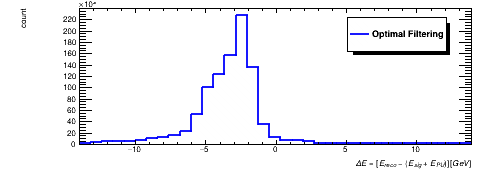

In [194]:

n_bins = 35
x_min = -14
x_max = 13.857

delta_e_arrays = [e_diff_of, e_diff_lin, e_diff_quad, e_diff_cubic]

filters = ['Optimal Filtering', 'Linear Fit', 'Quadratic Fit', 'Cubic Fit']


canvas = ROOT.TCanvas("canvas", "Signal Graph", 500, 200)
h1 = ROOT.TH1F(filters[0], filters[0], n_bins, x_min, x_max)

h1.SetContent(np.array(hist_of, dtype=np.float64))

h1.SetFillColorAlpha(ROOT.kBlue, 0)
h1.SetFillStyle(3005)

h1.SetLineWidth(2)
h1.SetLineColorAlpha(ROOT.kBlue, 0.9)

h1.GetYaxis().SetTitle("count")
h1.GetXaxis().SetTitle("\Delta E = [ E_{reco} - (E_{sig}+E_{PU})] [GeV]")

h1.Draw('hist')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(h1, filters[0], "fl")
legend.Draw()

canvas.SetLogy (0)
canvas.Update()
canvas.Draw()
canvas.Print('distr1.pdf')


## continue with the distribution of mean, std, 98% median

compare btwn filters

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file mean.pdf has been created


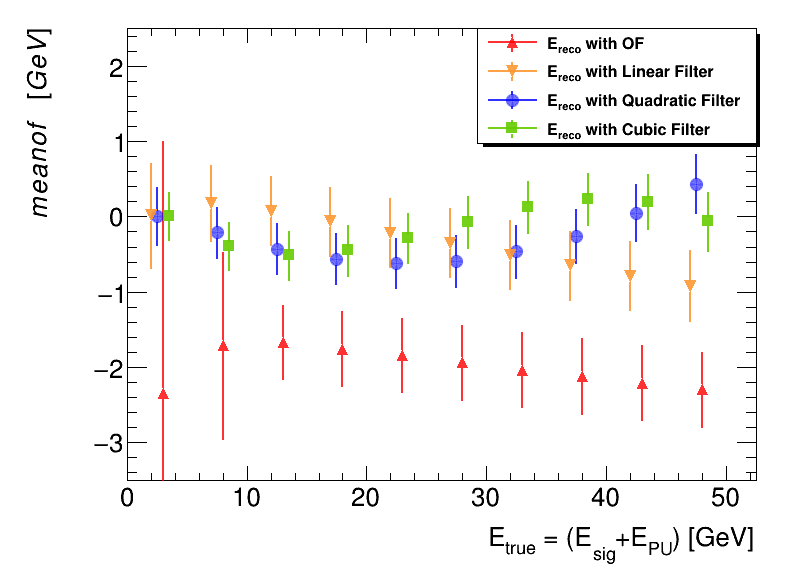

In [109]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)


graph1 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+0.5, np.array(mean_of, 'd'), np.zeros(len(x)), np.array(std_of, 'd'))
graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

graph2 = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(mean_quad, 'd'), np.zeros(len(x)), np.array(std_quad, 'd'))
graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph2.SetLineWidth(2)

graph3 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-0.5, np.array(mean_lin, 'd'), np.zeros(len(x)), np.array(std_lin, 'd'))
graph3.SetMarkerStyle(23)
graph3.SetMarkerSize(1.5)
graph3.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetLineWidth(2)

graph4 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+1, np.array(mean_cubic, 'd'), np.zeros(len(x)), np.array(std_cubic, 'd'))
graph4.SetMarkerStyle(21)
graph4.SetMarkerSize(1.4)
graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetLineWidth(2)

graph1.GetXaxis().SetTitle("E_{true} = (E_{sig}+E_{PU}) [GeV]")
graph1.GetYaxis().SetTitle("mean of \DeltaE [GeV]")
graph1.GetYaxis().SetRangeUser(-3.5, 2.5)


legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('mean.pdf')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file std.pdf has been created


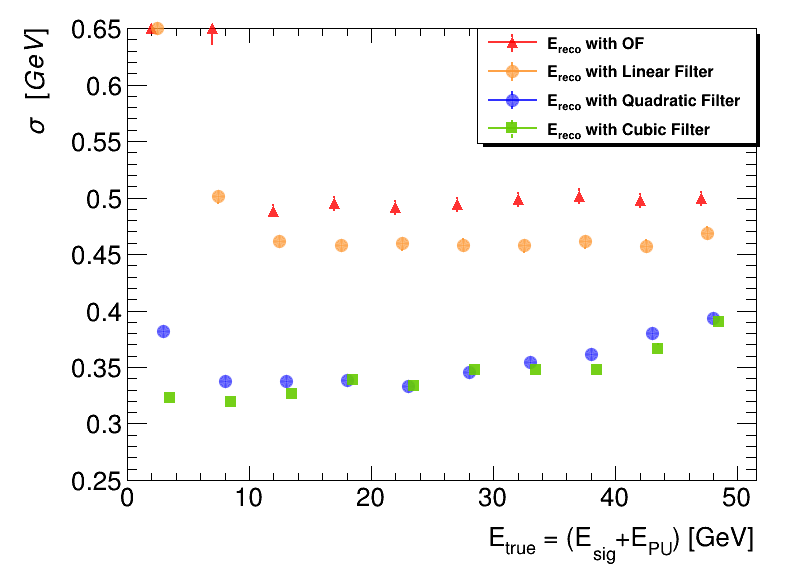

In [108]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

indice = [len(i) for  i in indices]
n = np.array(indice)

y = np.array(std_of)
uncertainty_y = y / np.sqrt(2 * n-2)
y[0] = 0.65
y[1] = 0.65
graph1 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-0.5, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

y = np.array(std_quad)
uncertainty_y = y / np.sqrt(2 * n-2)

graph2 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+0.5, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph2.SetLineWidth(2)

y = np.array(std_lin)
uncertainty_y = y / np.sqrt(2 * n-2)
y[0] = 0.65
graph3 = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph3.SetMarkerStyle(20)
graph3.SetMarkerSize(1.5)
graph3.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetLineWidth(2)

y = np.array(std_cubic)
uncertainty_y = y / np.sqrt(2 * n-2)

graph4 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+1, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph4.SetMarkerStyle(21)
graph4.SetMarkerSize(1.4)
graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetLineWidth(2)


graph1.GetXaxis().SetTitle("E_{true} = (E_{sig}+E_{PU}) [GeV]")
graph1.GetYaxis().SetTitle("\sigma_{\DeltaE}  [GeV]")
graph1.GetYaxis().SetRangeUser(0.25, 0.65)

legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('std.pdf')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file median.pdf has been created


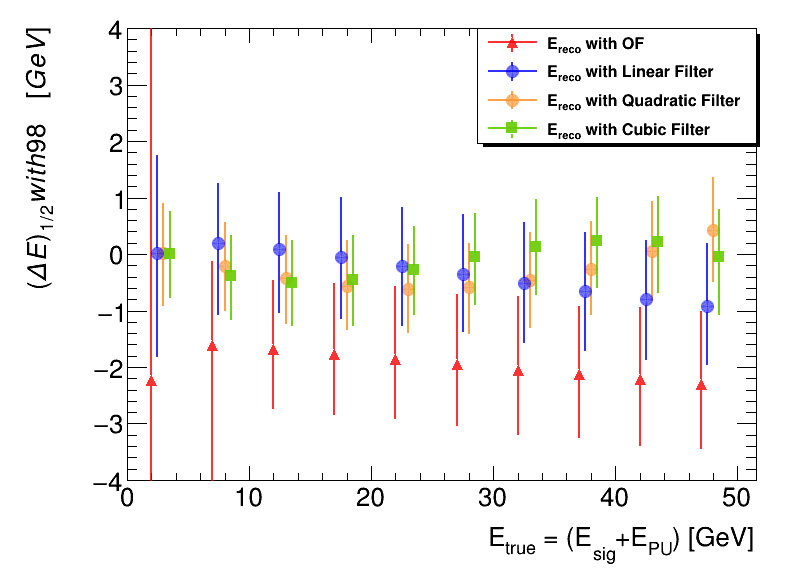

In [103]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

y = np.array(median_of, 'd')
lower_error = np.array(lower_98_of, 'd')  
upper_error = np.array(higher_98_of, 'd')  

graph1 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd')-0.5, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

y = np.array(median_quad, 'd')
lower_error = np.array(lower_98_quad, 'd')  
upper_error = np.array(higher_98_quad, 'd')  

graph2 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd')+0.5, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
graph2.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
graph2.SetLineWidth(2)


y = np.array(median_lin, 'd')
lower_error = np.array(lower_98_lin, 'd')  
upper_error = np.array(higher_98_lin, 'd')  
graph3 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd'), y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
graph3.SetMarkerStyle(20)
graph3.SetMarkerSize(1.5)
graph3.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph3.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph3.SetLineWidth(2)


y = np.array(median_cubic, 'd')
lower_error = np.array(lower_98_cubic, 'd')  
upper_error = np.array(higher_98_cubic, 'd')  
graph4 = ROOT.TGraphAsymmErrors(len(x), np.array(x, 'd')+1, y, np.zeros(len(x)), np.zeros(len(x)), y-lower_error, upper_error-y)
graph4.SetMarkerStyle(21)
graph4.SetMarkerSize(1.4)
graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetLineWidth(2)


graph1.GetXaxis().SetTitle("E_{true} = (E_{sig}+E_{PU}) [GeV]")
graph1.GetYaxis().SetTitle("(\Delta E)_{1/2} with 98% [GeV]")
graph1.GetYaxis().SetRangeUser(-4, 4)

legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('median.pdf')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


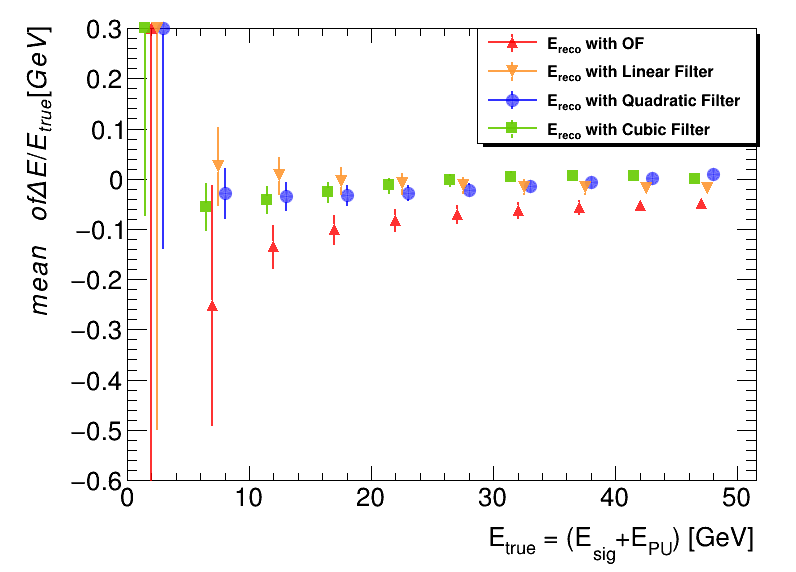

In [104]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

scale_mean_of[0], scale_mean_lin[0], scale_mean_quad[0], scale_mean_cubic[0] = 0.3, 0.3, 0.3, 0.3


graph1 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-0.5, np.array(scale_mean_of, 'd'), np.zeros(len(x)), np.array(scale_std_of, 'd'))
graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

graph2 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+0.5, np.array(scale_mean_quad, 'd'), np.zeros(len(x)), np.array(scale_std_quad, 'd'))
graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph2.SetLineWidth(2)

graph3 = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(scale_mean_lin, 'd'), np.zeros(len(x)), np.array(scale_std_lin, 'd'))
graph3.SetMarkerStyle(23)
graph3.SetMarkerSize(1.5)
graph3.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetLineWidth(2)

graph4 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-1, np.array(scale_mean_cubic, 'd'), np.zeros(len(x)), np.array(scale_std_cubic, 'd'))
graph4.SetMarkerStyle(21)
graph4.SetMarkerSize(1.4)
graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetLineWidth(2)

graph1.GetXaxis().SetTitle("E_{true} = (E_{sig}+E_{PU}) [GeV]")
graph1.GetYaxis().SetTitle("mean\ of \Delta E/E_{true} [GeV]")
graph1.GetYaxis().SetRangeUser(-0.6, 0.3)

legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file relative_std.pdf has been created


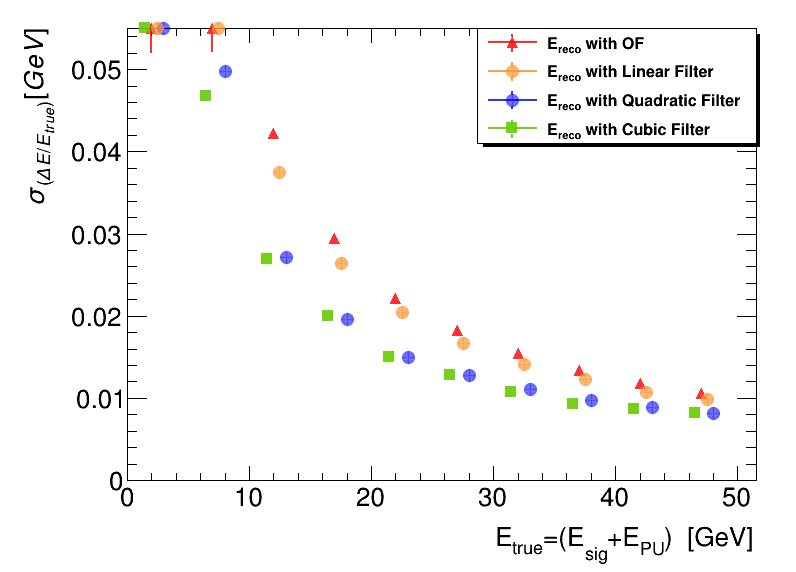

In [107]:
canvas = ROOT.TCanvas("canvas", "Comparison Canvas", 800, 600)

indice = [len(i) for  i in indices]
n = np.array(indice)

y = np.array(scale_std_of)
uncertainty_y = y / np.sqrt(2 * n-2)
y[0] = 0.055
y[1] = 0.055
graph1 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-0.5, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph1.SetMarkerStyle(22)
graph1.SetMarkerSize(1.5)
graph1.SetLineColorAlpha(ROOT.kRed, 0.8)
graph1.SetLineWidth(2)
graph1.SetMarkerColorAlpha(ROOT.kRed, 0.8)

y = np.array(scale_std_quad)
y[0] = 0.055
uncertainty_y = y / np.sqrt(2 * n-2)
graph2 = ROOT.TGraphErrors(len(x), np.array(x, 'd')+0.5, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph2.SetMarkerStyle(20)
graph2.SetMarkerSize(1.5)
graph2.SetLineColorAlpha(ROOT.kBlue, 0.8)
graph2.SetMarkerColorAlpha(ROOT.kBlue, 0.8)
graph2.SetLineWidth(2)

y = np.array(scale_std_lin)
y[0] = 0.055
y[1] = 0.055
uncertainty_y = y / np.sqrt(2 * n-2)
graph3 = ROOT.TGraphErrors(len(x), np.array(x, 'd'), np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph3.SetMarkerStyle(20)
graph3.SetMarkerSize(1.5)
graph3.SetLineColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetMarkerColorAlpha(ROOT.kOrange+1, 0.9)
graph3.SetLineWidth(2)

y = np.array(scale_std_cubic)
y[0] = 0.055
uncertainty_y = y / np.sqrt(2 * n-2)
graph4 = ROOT.TGraphErrors(len(x), np.array(x, 'd')-1, np.array(y, 'd'), np.zeros(len(x)), np.array(uncertainty_y, 'd'))
graph4.SetMarkerStyle(21)
graph4.SetMarkerSize(1.4)
graph4.SetLineColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetMarkerColorAlpha(ROOT.kSpring-8, 0.9)
graph4.SetLineWidth(2)

graph1.GetXaxis().SetTitle("E_{true}=(E_{sig}+E_{PU})  [GeV]")
graph1.GetYaxis().SetTitle("\sigma_{(\Delta E/E_{true})}  [GeV]")
graph1.GetYaxis().SetRangeUser(0., 0.055)
#graph1.GetYaxis().SetRangeUser(0., 1)

legend = ROOT.TLegend(0.6, 0.75, 0.95, 0.95)
legend.AddEntry(graph1, "E_{reco} with OF", "lep")
legend.AddEntry(graph3, "E_{reco} with Linear Filter", "lep")
legend.AddEntry(graph2, "E_{reco} with Quadratic Filter", "lep")
legend.AddEntry(graph4, "E_{reco} with Cubic Filter", "lep")

graph1.Draw("APE")
graph2.Draw("SAMEPE")
graph3.Draw("SAMEPE")
graph4.Draw("SAMEPE")
legend.Draw()

canvas.Update()
canvas.Draw()
canvas.Print('relative_std.pdf')

## other analyze method

not necessary

In [4]:
# calc the scaling factor and shift

energy_deposited = true_signal + pileup[n_start+10000: n_end+10000]

# Convolve the pulse shape with the energy deposited
convolved_sequence = np.convolve(energy_deposited, pulse, mode='same')

# Compare the convolved sequence with the ADC output
scaling_factor = np.max(convolved_sequence) / np.max(adc[n_start+10000: n_end+10000]) 

# Compare the time sequences for any shifts
shift = np.argmax(convolved_sequence) - np.argmax(adc[n_start+10000: n_end+10000])

(scaling_factor-1), shift

NameError: name 'true_signal' is not defined

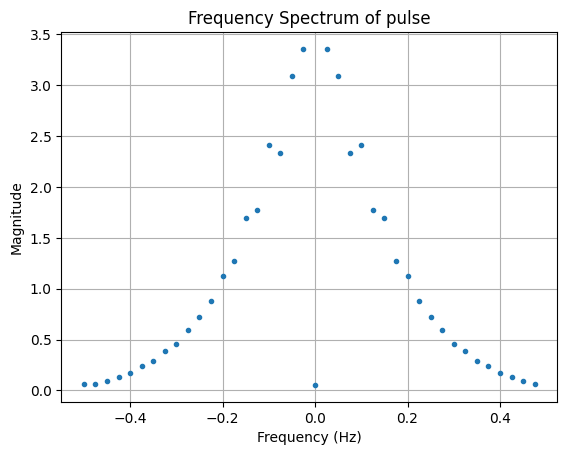

In [52]:
# spectral analysis

def plot_spectrum(signal, fs, name=''):
    spectrum = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), 1/fs) # TODO: why
    
    plt.figure()
    plt.plot(freq, np.abs(spectrum), '.')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum'+name)
    plt.grid(True)
    plt.show()


plot_spectrum(pulse, fs=1, name=' of pulse')

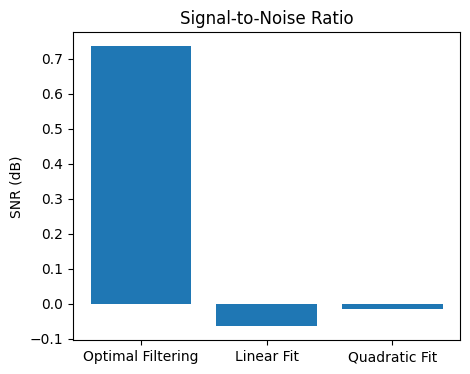

In [111]:
# SNR

def compute_snr(signal, noise):
    power_signal = np.mean(signal**2)
    power_noise = np.mean(noise**2)
    snr = 10 * np.log10(power_signal / power_noise)
    return snr

snr_of = compute_snr(of_pred, true_signal)
snr_linear = compute_snr(pred1, true_signal)
snr_quadratic = compute_snr(pred2, true_signal)

plt.figure(figsize=(5, 4))
plt.bar(['Optimal Filtering', 'Linear Fit', 'Quadratic Fit'], [snr_of, snr_linear, snr_quadratic])
plt.ylabel('SNR (dB)')
plt.title('Signal-to-Noise Ratio')
plt.grid(0)
plt.show()

